<h1> Approach<h1>

<h3>In order to understand better the patterns of the data, i will make use of libraries like matplotlib and seaborn to deep dive cases in the dataset and give better visibility on what is happening with the different types of Rossman drug stores.<h3>

In [8]:
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
import dvc

In [9]:
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

In [10]:
# changing string to date
def str_to_date(date):
      return datetime.strptime(date, '%Y-%m-%d').date()

<h3> Load the datasets <h3>

In [11]:
# reading a dataframe
df_train = pd.read_csv("../data/train.csv",sep=',', parse_dates=['Date'],low_memory = False)


In [12]:
# reading the store data
df_store = pd.read_csv("../data/store.csv",sep=',',low_memory = False)

In [13]:
# reading the test data
df_test = pd.read_csv("../data/test.csv",sep=',', parse_dates=['Date'], date_parser=str_to_date,
low_memory = False)

<h3>A quick view at the data on hand<h3>

In [14]:
df_train.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1.000000
1,2,5,2015-07-31,6064,625,1,1,0,1.000000
2,3,5,2015-07-31,8314,821,1,1,0,1.000000
3,4,5,2015-07-31,13995,1498,1,1,0,1.000000
4,5,5,2015-07-31,4822,559,1,1,0,1.000000


In [15]:
df_train.dtypes,print (f'The Train dataset has {str(df_train.shape[0])} Rows and {str(df_train.shape[1])} Variables')

The Train dataset has 688834 Rows and 9 Variables


(Store                     int64
 DayOfWeek                 int64
 Date             datetime64[ns]
 Sales                     int64
 Customers                 int64
 Open                      int64
 Promo                     int64
 StateHoliday             object
 SchoolHoliday           float64
 dtype: object,
 None)

<h3>Calculating how many missing fields each variable has<h3>

In [16]:
df_train.count(0)/df_train.shape[0] * 100

Store           100.000000
DayOfWeek       100.000000
Date            100.000000
Sales           100.000000
Customers       100.000000
Open            100.000000
Promo           100.000000
StateHoliday     99.999855
SchoolHoliday    99.999855
dtype: float64

### no missing value found on train data set but a closer look at the Train set is needed


### let us see Stores Closed (which means 0 customers and 0 sales) on Certain days:

In [17]:
print ()
print (f"-Over those two years, {df_train[(df_train.Open == 0)].count()[0]} is the number of times that different stores closed on given days.")
print ()
print (f"-From those closed events, {df_train[(df_train.Open == 0) & (df_train.SchoolHoliday == 1)&(df_train.StateHoliday == '0') ].count()[0]} times occured because there was a school holiday. ")
print ()
print ("-And {} times it occured because of either a bank holiday or easter or christmas.".format(df_train[(df_train.Open == 0) &
         ((df_train.StateHoliday == 'a') |
          (df_train.StateHoliday == 'b') | 
          (df_train.StateHoliday == 'c'))].count()[0]))
print ()
print ("-But interestingly enough, {} times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.".format(df_train[(df_train.Open == 0) &
         (df_train.StateHoliday == "0")
         &(df_train.SchoolHoliday == 0)].count()[0]))
print ()


-Over those two years, 0 is the number of times that different stores closed on given days.

-From those closed events, 0 times occured because there was a school holiday. 

-And 0 times it occured because of either a bank holiday or easter or christmas.

-But interestingly enough, 0 times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.



### since we don't want to bias our models to consider those exceptions, the best solution here is to get rid of closed stores and prevent the models to train on them and get false guidance.

### In this case we will analyse only open stores since a close store yield a profit of 0.

In [18]:
df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)

In [19]:
df_train = df_train.reset_index(drop=True)

In [20]:
train_path = ('../data/train.csv')

In [21]:
df_train.to_csv(train_path, index= False)

In [22]:
print ("Our new training set has now {} rows ".format(df_train.shape[0]))

Our new training set has now 688834 rows 


## checking any outliers in the distribution of Sales and Customers in the train set

## 1)sales

In [23]:
df_train.Sales.describe()

count   688834.000000
mean      7014.331662
std       3122.426423
min         46.000000
25%       4903.000000
50%       6418.000000
75%       8428.000000
max      41551.000000
Name: Sales, dtype: float64

### we see here a minimum of 0 which means some stores even opened got 0 sales on some days. since that can't happen we will drop it

In [24]:
df_train=df_train.drop(df_train[(df_train.Open == 1) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True) 

An important metric to always check when looking at a distribution is how the mean compares to the median and how close are they from each other. As we see here a mean of 6955 versus 6369 in median is a very good sign that there are no extravagant values affecting the general distribution of Sales.

## 2) customer

In [25]:
df_train.Customers.describe()    

count   688834.000000
mean       765.589286
std        401.735661
min          8.000000
25%        522.000000
50%        678.000000
75%        895.000000
max       5494.000000
Name: Customers, dtype: float64

## Here there is huge difference between mean and median. This is due to a huge amount of customers in a store,When there is a big promotion going on. 

In [26]:
df_train.to_csv(train_path,index= False)

In [27]:
df_store.head() 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0
1,2,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0
4,5,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0


In [28]:
df_store.dtypes,print (f'The Store dataset has {str(df_store.shape[0])} Rows and {str(df_store.shape[1])} Variables')

The Store dataset has 1115 Rows and 10 Variables


(Store                          int64
 StoreType                     object
 Assortment                    object
 CompetitionDistance          float64
 CompetitionOpenSinceMonth    float64
 CompetitionOpenSinceYear     float64
 Promo2                         int64
 Promo2SinceWeek              float64
 Promo2SinceYear              float64
 PromoInterval                 object
 dtype: object,
 None)

### let us look further in to store data

In [29]:
# calculating fill rate
df_store.count(0)/df_store.shape[0] * 100

Store                       100.000000
StoreType                   100.000000
Assortment                  100.000000
CompetitionDistance         100.000000
CompetitionOpenSinceMonth   100.000000
CompetitionOpenSinceYear    100.000000
Promo2                      100.000000
Promo2SinceWeek             100.000000
Promo2SinceYear             100.000000
PromoInterval               100.000000
dtype: float64

### CompetitionOpenSinceMonth and CompetitionOpenSinceYear, it's  missing data that we're dealing with here (68.25% fill rate), this means that we have the nearest distance of the competitor but miss the date information on when did he actually opened next to the Rossman store.

### But The Promo2SinceWeek,Promo2SinceYear and PromoInterval variables has 51% fill rate since they are actually NULL values because there are no continuous promotion for those stores.


## Dealing with the missing value

### computing missing value for Competition Distance

In [30]:
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


### only 3 rows with null values for Competition Distance Before deciding how to treat this, Let's quickly have a look at those metrics.

{'Mean': 5396.614349775785,
 'Median': 2325.0,
 'Standard Dev': 7651.080347770843}

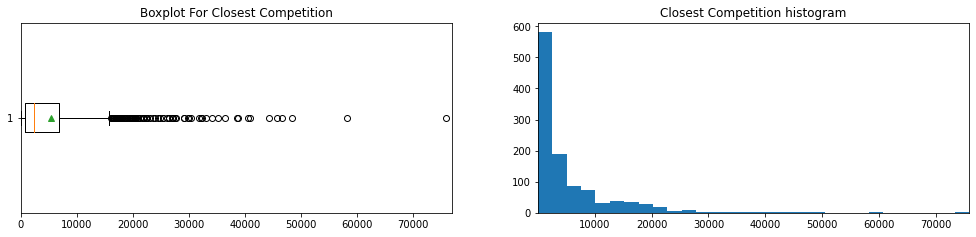

In [31]:
df_store_check_distribution=df_store.drop(df_store[pd.isnull(df_store.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_store_check_distribution.CompetitionDistance, showmeans=True,vert=False,)
axes[0].set_xlim(0,max(df_store_check_distribution.CompetitionDistance+1000))
axes[0].set_title('Boxplot For Closest Competition')
axes[1].hist(df_store_check_distribution.CompetitionDistance, cumulative=False, bins=30)
axes[1].set_title("Closest Competition histogram")
axes[1].set_xlim((min(df_store_check_distribution.CompetitionDistance), max(df_store_check_distribution.CompetitionDistance)))
{"Mean":np.nanmean(df_store.CompetitionDistance),"Median":np.nanmedian(df_store.CompetitionDistance),"Standard Dev":np.nanstd(df_store.CompetitionDistance)}

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

SO it is realistically better to input the median value to the three Nan stores then the mean since the mean is biased by those outliers.

In [32]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

### computing missing value for CompetitionOpenSinceMonth and CompetitionOpenSinceYear

Since we have no information whatsoever on those missing values and no accurate way of filling those values. I assigned zero to the missing value

In [33]:
df_store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)

### computing missing value for Promo2SinceWeek, Promo2SinceYear and PromoInterval

In [34]:
df_store[pd.isnull(df_store.Promo2SinceWeek)]


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [35]:
df_store[pd.isnull(df_store.Promo2SinceWeek)& (df_store.Promo2==0)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


This means all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores. Having no promotion means those fields have to be 0 as well since they are linked to Promo2. so we will place zero in the missing value place


In [36]:
# filling missing value for the three column
df_store.Promo2SinceWeek.fillna(0,inplace=True)
df_store.Promo2SinceYear.fillna(0,inplace=True)
df_store.PromoInterval.fillna(0,inplace=True)

In [37]:
# checking for missing values on the store data
df_store.count(0)/df_store.shape[0] * 100

Store                       100.000000
StoreType                   100.000000
Assortment                  100.000000
CompetitionDistance         100.000000
CompetitionOpenSinceMonth   100.000000
CompetitionOpenSinceYear    100.000000
Promo2                      100.000000
Promo2SinceWeek             100.000000
Promo2SinceYear             100.000000
PromoInterval               100.000000
dtype: float64

In [38]:
# saving df_store to csv file
df_store.to_csv('../data/store.csv', index= False)

## Merging train and store data set using left join

In [39]:
df_train_store = pd.merge(df_train, df_store, how = 'left', on = 'Store')
df_train_store.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1.000000,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1.000000,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1.000000,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1.000000,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1.000000,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0


In [40]:
print ("The Train_Store dataset has {} Rows and {} Variables".format(str(df_train_store.shape[0]),str(df_train_store.shape[1])))

The Train_Store dataset has 688834 Rows and 18 Variables


In [60]:
df_train_store.to_csv('../data/train_store.csv', index= False)

In [41]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.000000,1,0,0
1,2,3,4,2015-09-17,1.000000,1,0,0
2,3,7,4,2015-09-17,1.000000,1,0,0
3,4,8,4,2015-09-17,1.000000,1,0,0
4,5,9,4,2015-09-17,1.000000,1,0,0


In [42]:
df_train.dtypes,print (f'The test dataset has {str(df_test.shape[0])} Rows and {str(df_test.shape[1])} Variables')

The test dataset has 41088 Rows and 8 Variables


(Store                     int64
 DayOfWeek                 int64
 Date             datetime64[ns]
 Sales                     int64
 Customers                 int64
 Open                      int64
 Promo                     int64
 StateHoliday             object
 SchoolHoliday           float64
 dtype: object,
 None)

In [43]:
# calculating missing values
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

### only open column has missing values

# Plotting  distribution of promotion in both Data sets 

In [51]:
def plot_dist(df:pd.DataFrame, column):
    plt.figure(figsize=(9,7))
    sns.distplot(column).set_title(f'Distribution of {column}')
    

Text(0.5, 1.0, 'Promotion histogram for test')

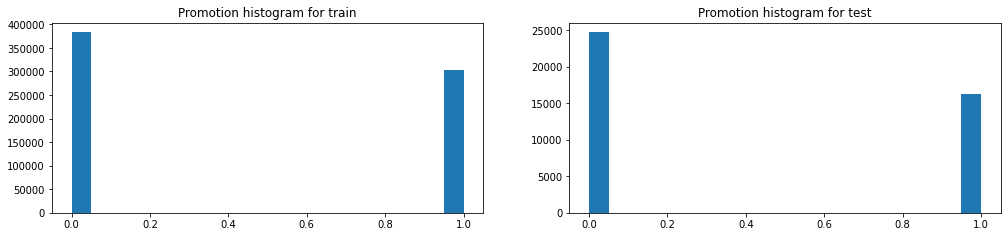

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].hist(df_train_store.Promo, cumulative=False, bins=20)
axes[0].set_title("Promotion histogram for train")
axes[1].hist(df_test.Promo, cumulative=False, bins=20)
axes[1].set_title("Promotion histogram for test")

## Promotion

Let's see how Promotion affect the overall sales of Rossman by looking at when there is and when there isn't promotion over those 3 years. This allow us first to see the impact of promotion and as well to see the evolution of sales over specific years (so trends in a given year) and the gradual increase in sales from 2013 to 2015.

In [62]:
# creating month and year columns  
df_train_store['Month']=df_train_store.Date.dt.month
df_train_store['Year']=df_train_store.Date.dt.year

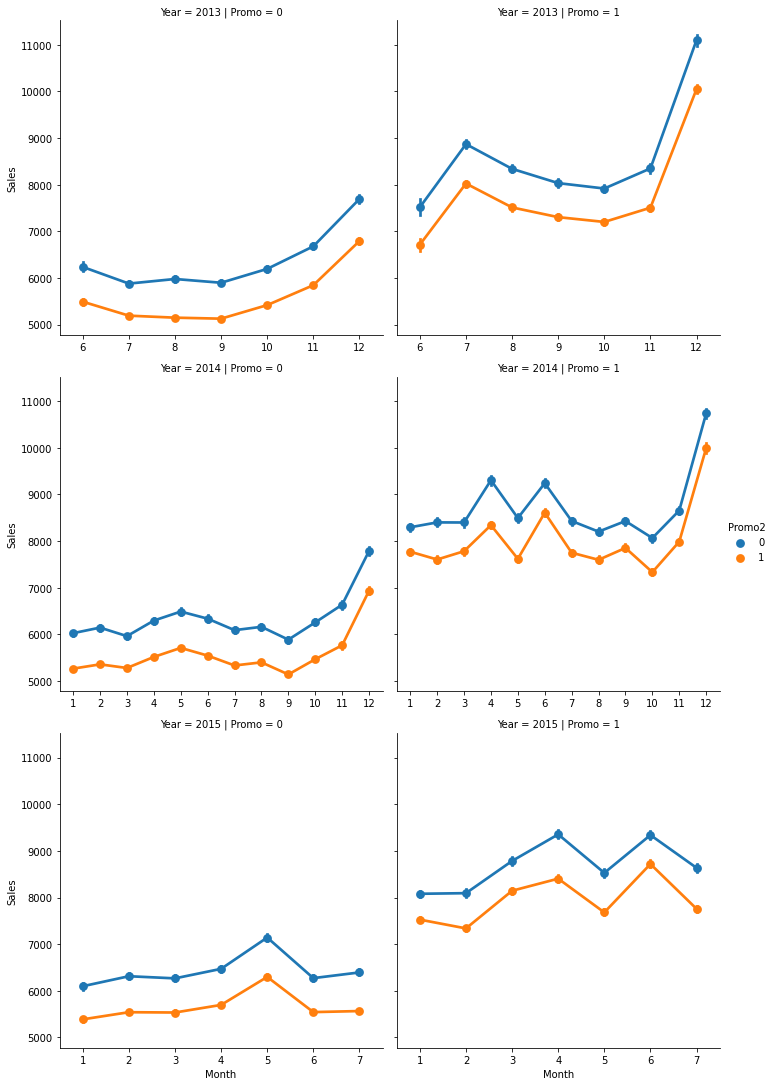

In [63]:
sns.factorplot(data = df_train_store, x ="Month", y = 'Sales',col = 'Promo',  hue = 'Promo2', row = 'Year' ,sharex=False)

We can see that there is a great change when we compare having promotion Promo=1 to not having promotion Promo=0 and can conclude that a store that have promotion on a given day changes its amount of sales considerably.

## Now let us check if the promos attracting more customers

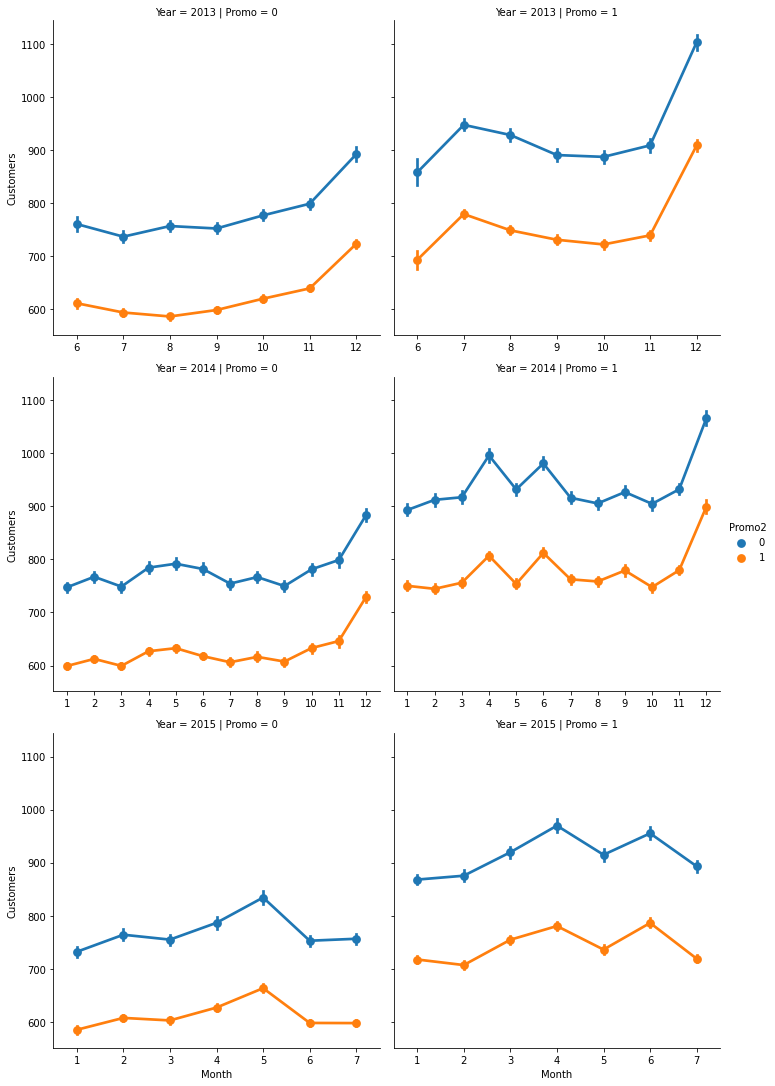

In [64]:
sns.factorplot(data = df_train_store, x ="Month", y = 'Customers',col = 'Promo',  hue = 'Promo2', row = 'Year' ,sharex=False)

## Here we can see that there is a change in the number of customers when we compare having promotion Promo=1 to not having promotion Promo=0 and also a growth from to year to year. Eventhough there is a change the change is not as much as sales. so we can conclude that the promos are attracting new customers but the increasing rate of customers and increasing rate of sales is not equivalent.

## To see how it affect already existing customers let us create new columns called sales per customer.

In [66]:
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1.000000,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0,7,2015,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1.000000,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",7,2015,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1.000000,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",7,2015,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1.000000,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0,7,2015,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1.000000,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0,7,2015,8.626118


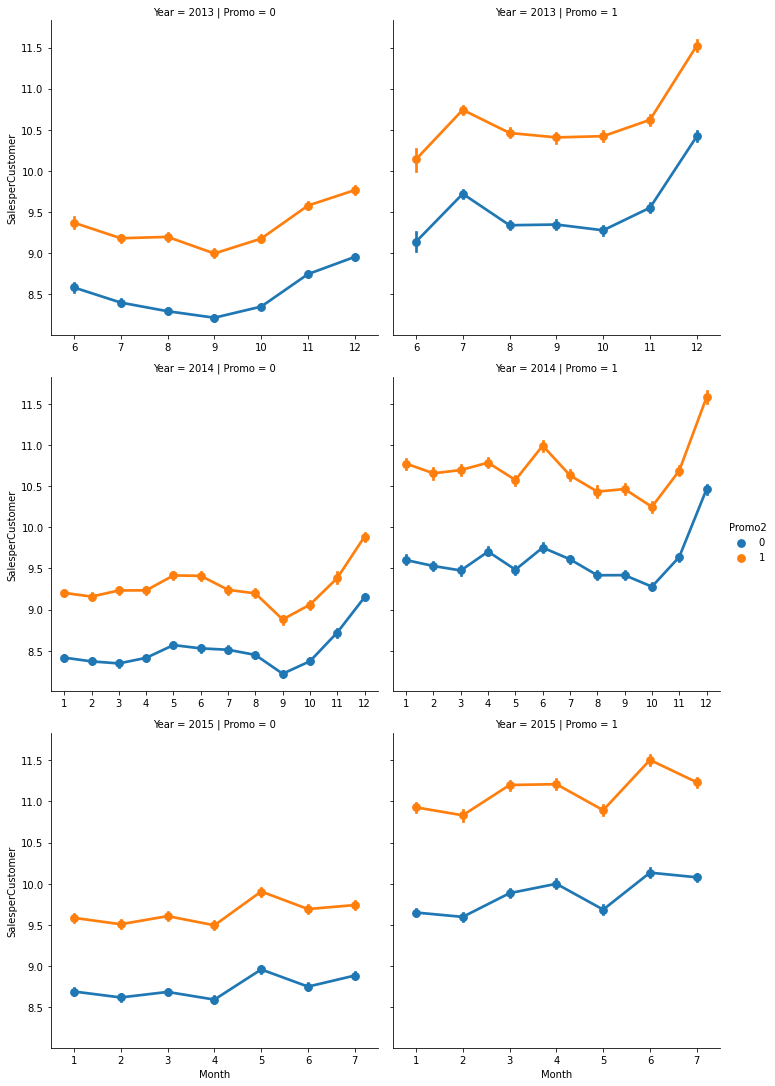

In [67]:
sns.factorplot(data = df_train_store, x ='Month', y = 'SalesperCustomer', col = 'Promo', hue = 'Promo2',row = 'Year',sharex=False)

## As we can see from the graph the sales per customer has increased when there is promotion.From the graphs we can conclude that the existing customer are buying more due to the promotion.  